In [1]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial import KDTree
from scipy.linalg import sqrtm

In [41]:
p = 3
n = 500
# locations of observations (1x1 square domain)
s = np.random.rand(n,2)

In [42]:
K = rbf_kernel(s, s, gamma=1) + 1e-6*np.eye(n)
z = np.random.multivariate_normal(np.zeros(n), K, p)

# center the data:
z = z - z.mean(axis=1)[:, np.newaxis]

In [43]:
# mixing matrix
O = np.random.normal(size=(p,p))
x = O @ z

# whiten so that SOBIsym works
W = np.linalg.inv(sqrtm(np.cov(x)))
x = W @ x

In [44]:
def calculate_local_covariance(points, radius, variables):
    """
    Calculates the covariance matrix for points within a certain radius for each point.

    Args:
        points (np.ndarray): A NumPy array of shape (N, D) where N is the number of
                             points and D is the dimension (e.g., 3 for 3D points).
        radius (float): The radius within which to search for neighbors.
        variables (np.ndarray): a NumPy array of shape (N, P) where P is the dimension
                            of the variables

    Returns:
        np.ndarray: PxP matrix of the covariance
    """
    # Build a KD-Tree for efficient spatial searching
    tree = KDTree(points)
    
    # List to store the covariance matrix for each point
    covariance_matrix = np.zeros((variables.shape[1], variables.shape[1]))
    
    # Iterate over each point
    for i, query_point in enumerate(points):
        # Find indices of points within the specified radius
        # search_radius_vector_3d (as mentioned in Open3D docs) has a similar KDTree method in scipy
        neighbor_indices = tree.query_ball_point(query_point, radius)
        
        # Select the neighboring points
        neighbors = variables[neighbor_indices]
        
        covariance_matrix += np.einsum('ij, ik -> jk', neighbors, neighbors)
            
    return covariance_matrix / variables.shape[0]

In [45]:
# calculate local covariance matrices
M01 = calculate_local_covariance(s, 0.1, x.T)
M005 = calculate_local_covariance(s, 0.05, x.T)
M0025 = calculate_local_covariance(s, 0.025, x.T)
M001 = calculate_local_covariance(s, 0.01, x.T)
M = np.stack((M01, M005, M0025, M001), axis=1)

In [46]:
M.shape

(3, 4, 3)

In [47]:
def H(g, S):
    # shape of S (p,k,p)
    return np.tensordot(g, S, axes=([0],[0])) @ g @ (S @ g).T

In [48]:
G = np.eye(p)
for i in range(5000):
    for j in range(p):
        G[j,:] = H(G[j,:], M)
    # orthogonalize
    U, Sigma, V = np.linalg.svd(G)
    G = U @ V.T

In [49]:
# off-diagonals are minimized
G @ M01 @ G.T, G @ M005 @ G.T, G @ M0025 @ G.T, G @ M001 @ G.T

(array([[14.39968546,  0.23798309,  0.6598687 ],
        [ 0.23798309, 14.1097186 ,  0.33660837],
        [ 0.6598687 ,  0.33660837, 14.86924926]]),
 array([[4.74056634, 0.0207428 , 0.19008157],
        [0.0207428 , 4.78342527, 0.02497513],
        [0.19008157, 0.02497513, 4.4985073 ]]),
 array([[ 2.0995052 , -0.01982782,  0.08518432],
        [-0.01982782,  2.08311026,  0.02729737],
        [ 0.08518432,  0.02729737,  1.88138149]]),
 array([[ 1.12175669, -0.01246811,  0.04032073],
        [-0.01246811,  1.11591183,  0.00457173],
        [ 0.04032073,  0.00457173,  1.13291298]]))

In [50]:
# G is orthogonal
G @ G.T

array([[ 1.00000000e+00,  3.20600350e-16, -5.62210320e-16],
       [ 3.20600350e-16,  1.00000000e+00, -6.13776926e-16],
       [-5.62210320e-16, -6.13776926e-16,  1.00000000e+00]])

In [39]:
from scipy.optimize import linear_sum_assignment

def MDI(G):
    Gt = G**2 / (np.linalg.norm(G, axis=1)**2)[:, np.newaxis]
    cost = np.ones_like(Gt) - 2*Gt - (Gt**2).sum(axis=1)[:, np.newaxis]
    row_ind, col_ind = linear_sum_assignment(cost, maximize=False)
    perm = np.argsort(col_ind)
    return (G.shape[0] - (Gt[row_ind, col_ind]).sum())**0.5 / (G.shape[0] - 1)**0.5

In [52]:
MDI(G @ (W @ O))

np.float64(0.8919044954049644)

In [27]:
G @ (W @ O)

array([[ 2.20118044,  2.00450374, -0.40944427],
       [-0.3660142 , -1.99283084, -0.11020681],
       [ 0.791414  ,  2.68308803, -2.26578611]])

In [157]:
r,c = MDI(G @ (W @ O))
A = G @ (W @ O)[np.argsort(c)] 
A @ np.diag(1/np.diag(A))

array([[ 1.        , -0.33854226,  0.11261238],
       [ 0.43799219,  1.        , -0.40130186],
       [-0.08692056, -0.95021267,  1.        ]])

In [23]:
((X / np.linalg.norm(X, axis=1)[:, np.newaxis])**2).sum(axis=1)

array([1., 1., 1.])

In [143]:
G @ G.T

array([[1.00000000e+00, 2.04184287e-16, 1.10684422e-16],
       [2.04184287e-16, 1.00000000e+00, 2.54946770e-17],
       [1.10684422e-16, 2.54946770e-17, 1.00000000e+00]])

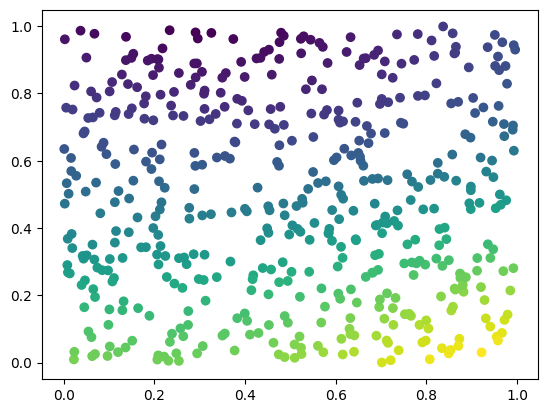

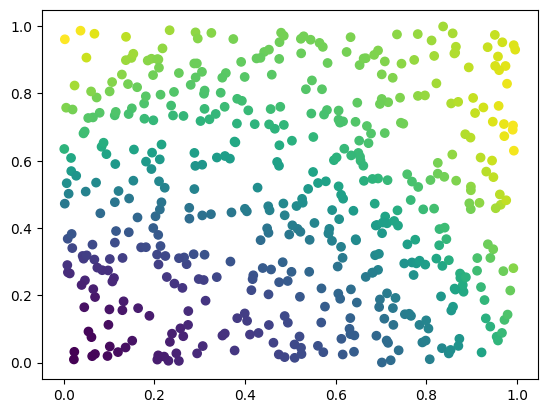

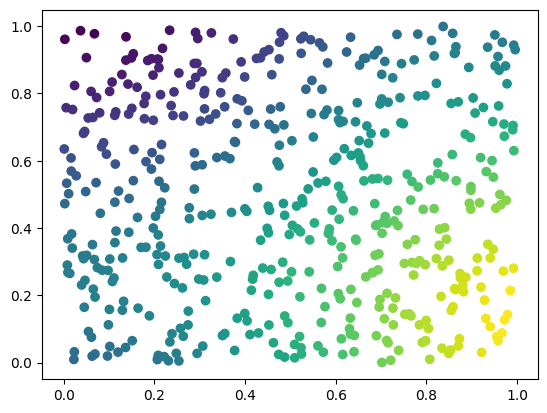

In [51]:
import matplotlib.pyplot as plt
plt.scatter(s.T[0], s.T[1], c = z[0])
plt.show()
plt.scatter(s.T[0], s.T[1], c = z[1])
plt.show()
plt.scatter(s.T[0], s.T[1], c = z[2])
plt.show()